First I need to install pytorch lighting wjich make coe shorter.

In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 17.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [ ]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

# generate the seed random number:

# Create data loader

In [ ]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),           ## transforms.ToTensor(): This just converts your input image to PyTorch tensor.
                transforms.Normalize((0.1307,), (0.3081,)),   ### Normalize the dataset, Here (0.1307,): mean and (0.3081,): std value
            ]
        )
    # defind function for download data using flag
    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)  ## this down load train dataset
        MNIST(self.data_dir, train=False, download=True)  ## this down load test dataset

    def setup(self, stage=None):
        # Assign train/validation datasets ( splite the train and validation dataset)
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])     ### splite train and validation dataset

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform) ### splite ttest dataset

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

# Create Discreminator class

In [ ]:
# Detective: fake or no fake -> 1 output [0, 1]   ## fake--> o and no fake -->1
class Discriminator(nn.Module):      ## call the cnn from nn.module
    def __init__(self):
        super().__init__()
        # Simple CNN with 2 convolution layers
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)   # in ch=1, out ch==10, kernel==5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)   # output= 1

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)   # sigmoid privides us either 0 or 1 output

# Create Generator class

In [ ]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):                                             # laten_dim is scalar value ??? but output== [-1, 1]
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]              # create linear layere
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]     ## ConvTranspose == input imape to upsample
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]     ## ConvTranspose == input imape to upsample
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]           ## ConvTranspose == input imape to downsample


    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

# Creat GAN class

In [ ]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
      super().__init__()
      self.save_hyperparameters()
      self.automatic_optimization = False  ### new update

      self.generator = Generator( latent_dim = self.hparams.latent_dim)
      self.discriminator= Discriminator()

      # add random Noise
      self.validation_z = torch.randn( 6, self.hparams.latent_dim)

    def forward(self, z):
      return self.generator(z)

    ## Create loss function
    def advarsarial_loss(self, y_hat, y):
      return F.binary_cross_entropy( y_hat, y)


    ## defind training steps:
    def training_step(self, batch, batch_idx):
      real_imgs, _ = batch                                     # unpack batch from dataset
      g_opt, d_opt = self.optimizers()

      ## create sample noise data
      z= torch.randn( real_imgs.shape[0], self.hparams.latent_dim)
      z = z.type_as(real_imgs)                                 # if GPU is the ncall GPU

      ## train generator:  max log(D(G(z)))
      if g_opt == 0:
        fake_imgs = self(z)
        y_hat = self.discriminator(fake_imgs)

        y= torch.ones(real_imgs.size(0), 1)
        y= y.type_as(real_imgs)

        g_loss = self.adversarial_loss(y_hat, y)
        log_dict = { "g_loss": g_loss}
        return { "loss ": g_loss, " progress_bar": log_dict, "log": log_dict }


      ## train  Discriminator image: max log (D(x)) + log(1- D(G(z)))
      if d_opt == 1:

        ## how well can it label as real
         y_hat_real = self.discriminator(real_imgs)

         y_real = torch.ones(real_imgs.size(0), 1)
         y_real = y_real.type_as(real_imgs)

         real_loss = self.adversarial_loss(y_hat_real, y_real)

        ## how well can it label as Fake
         y_hat_fake = self.discriminator(self(z).detch() )


         y_fake = torch.zeros(real_imgs.size(0), 1)
         y_fake = y_fake.type_as(real_imgs)

         fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        ## combine two losses
         d_loss = ( real_loss + fake_loss)/2
         log_dict = { "d_loss ": d_loss}
         return {"loss": d_loss, "progress_bar": log_dict, "log": log_dict }


      ## defind optimizer function
    def configure_optimizers( self):
      lr=self.hparams.lr
      opt_g= torch.optim.Adam(self.generator.parameters(), lr=lr)
      opt_d= torch.optim.Adam(self.discriminator.parameters(), lr=lr)
      return [opt_g, opt_d], []

    ### during each epoch plot each of fake image
    def plot_imgs(self):
      z = self.validation_z.type_as(self.generator.lin1.weight)  ## this call GPU
      sample_imgs = self(z).cpu()                              ## if GPU is not avaiable the call CPU to generate fake image of generator(z) of faorward pass

      print( "epoch ", self.current_epoch)
      fig = plt.figure()
      for i in range( sample_imgs.size(0)):
        plt.subplot(2, 3, i+1)
        plt.tight_layout()
        plt.imshow(sample_imgs.detach() [i, 0, :, :], cmap= 'gray_r', interpolation='none')
        plt.title("Generated Data")
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
      plt.show()

    def on_epoch_end(self):
      self.plot_imgs()


# create

In [ ]:
dm = MNISTDataModule()
model= GAN()

# Plot Noise

epoch  0


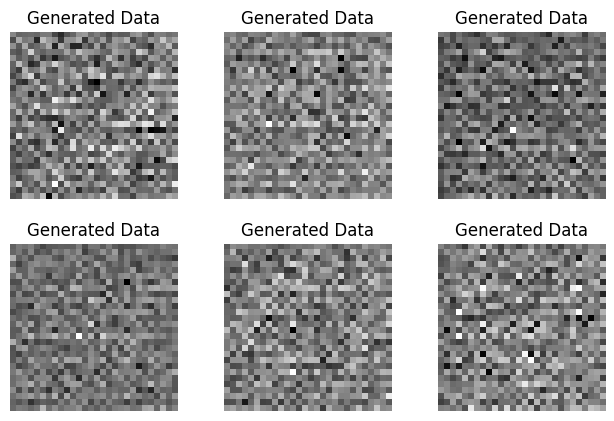

In [ ]:
model.plot_imgs()

# Train model

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


epoch  50


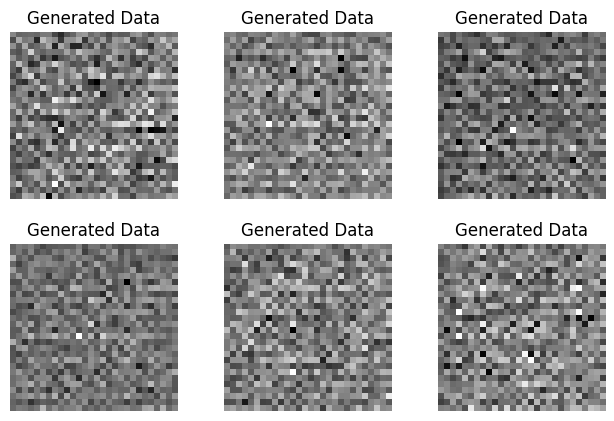

In [ ]:
trainer = pl.Trainer(max_epochs=50, devices='auto')
trainer.fit(model, dm)
model.plot_imgs()
